## This script demonstrates the process of generating kappa and gamma values from both halo and GLASS data sources, and how to visualize the joint distribution of the total kappa and gamma values.

First, we import necessary modules and classes from `sim_pipeline.halos.halos_plus_glass` and `astropy.cosmology`. We also define our cosmology model using `FlatLambdaCDM` with parameters `H0=70` and `Om0=0.3`.
Next, we read the glass data from the file `"z5data.npy"` using the `read_glass_data` function. It returns the kappa values, gamma values, and nside. Then, we calculate the sky area using `skyarea_form_n` function with the `nside`.

In [1]:
# TODO: make it more realistic including:                                                                                           1. use z5data.npy(~780MB) and make n from generate_samples_from_glass.() equal a higher number.                                  2. In generate_meanzero_halos_multiple_times(n_times=5, skypy_config=None, skyarea=0.0001, cosmo=cosmo, samples_number_for_one_halos=1000, renders_numbers=200) let skyarea=skyarea, n_times larger.                                      3. For lower halo mass min? (now 5*10^11)
from slsim.Halos.halos_plus_glass import read_glass_data,skyarea_form_n,generate_samples_from_glass,halos_plus_glass
import os
from astropy.cosmology import FlatLambdaCDM
from slsim.Halos.halos_plus_glass import run_halos_without_kde_by_multiprocessing
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
file_path = os.path.join(parent_directory, 'sim_pipeline/Halos/z5data.npy')

kappa_values, gamma_values, nside = read_glass_data(file_name=file_path)
skyarea = skyarea_form_n(nside)
kappa_random_glass, gamma_random_glass = generate_samples_from_glass(kappa_values, gamma_values, n=5000)
print(kappa_random_glass.shape)

C:\Users\TXZ27\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


(5000,)


### After that, we generate kappa and gamma values from halos using `run_halos_without_kde` or `run_halos_without_kde_by_multiprocessing` function. These functions repeat the generation of halos `n_iterations` times and accumulates the results.
##### For `n_iterations` is large (>10), using ` run_halos_without_kde_by_multiprocessing` will be faster.
###### for example, for `n_iterations=25, sky_area=0.0001, samples_number=200,cosmo=cosmo,                                                              m_min=None, m_max=None, z_max=None` :
        `run_halos_without_kde_by_multiprocessing` takes ~ 50 secs
        `run_halos_without_kde` takes ~ 200 secs


In [2]:

#nk,ng = run_halos_without_kde(n_iterations=25, sky_area=0.0001, samples_number=200,cosmo=cosmo,                                                              m_min=None, m_max=None, z_max=None)

nk,ng = run_halos_without_kde_by_multiprocessing(n_iterations=50, sky_area=0.0001, samples_number=100,cosmo=cosmo,                                                              m_min=None, m_max=None, z_max=None)
mean_kappa = np.mean(nk)
kappa_random_halos, gamma_random_halos = nk - mean_kappa,ng

The 50 halo-lists took 151.89858436584473 seconds to run


The total kappa and gamma values are then calculated by combining the values from halo and glass data sources. This is done by the `halos_plus_glass` function.

In [3]:
total_kappa, total_gamma = halos_plus_glass(kappa_random_glass, gamma_random_glass, kappa_random_halos, gamma_random_halos)

Finally, we visualize the joint distribution of the total kappa and gamma values using a hexbin plot.
We also fit a Gaussian KDE to the joint distribution of kappa and gamma values and generate a random sample from this distribution.
The joint distribution of the resampled kappa and gamma values is also visualized using a hexbin plot.

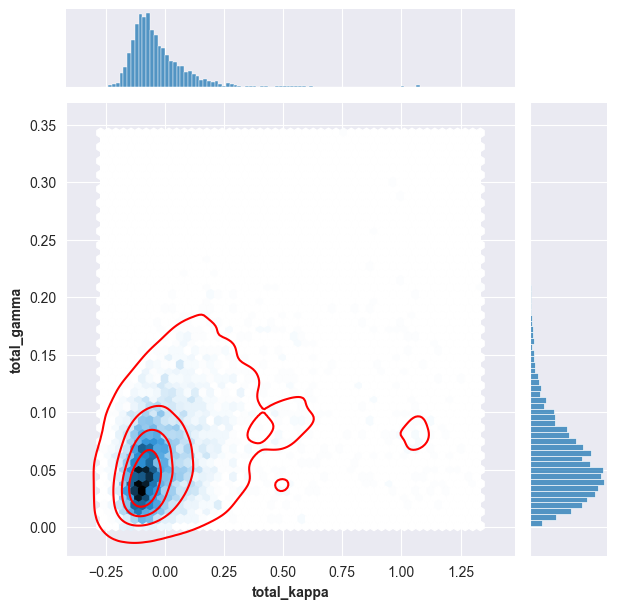

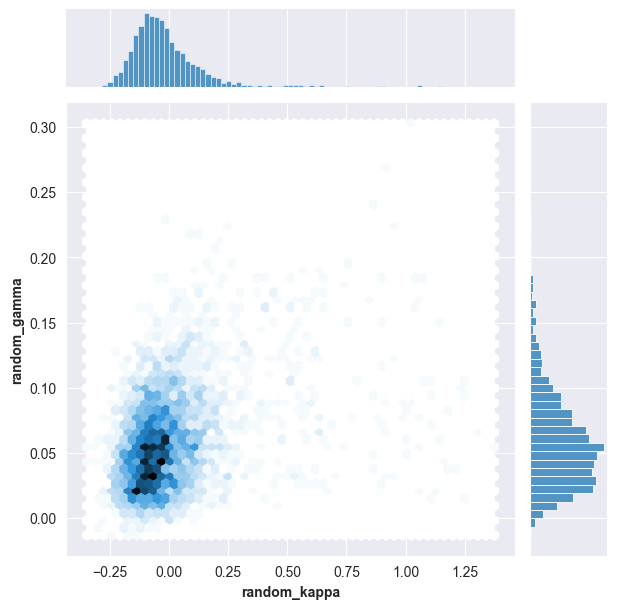

In [4]:

total_plot = sns.jointplot(x=total_kappa, y=total_gamma,kind='hex')
total_plot.plot_joint(sns.kdeplot, color="r", zorder=3, levels=5)
total_plot.ax_joint.set_xlabel('total_kappa', fontweight='bold')
total_plot.ax_joint.set_ylabel('total_gamma', fontweight='bold')
plt.show()

# Use Gaussian KDE to fit the joint distribution
kernel = stats.gaussian_kde(np.vstack([total_kappa, total_gamma]))
n = 3000  # Number of random numbers to generate
kappa_random, gamma_random = kernel.resample(n)
modified_plot = sns.jointplot(x=kappa_random, y=gamma_random, kind='hex')
modified_plot.ax_joint.set_xlabel('random_kappa', fontweight='bold')
modified_plot.ax_joint.set_ylabel('random_gamma', fontweight='bold')
plt.show()
# TODO: make gamma render by KDE >0